## Loading essential libraries 

In [ ]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

from gensim.models import KeyedVectors

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Download Corpora 

List downloaded dataset: 
* Universal Tagset 
* Penn Treebank 
* Brown 
* CoNLL-U 2000 

In [ ]:
import nltk
nltk.download('universal_tagset')
nltk.download('treebank')
nltk.download('brown')
nltk.download('conll2000')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.


True

# Preprocess Data
Using POS Tagged Corpora from NLTK


In [ ]:
# load POS tagged corpora from NLTK
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

In [ ]:
# Quick look at dataset 
tagged_sentences[7]

[('A', 'DET'),
 ('Lorillard', 'NOUN'),
 ('spokewoman', 'NOUN'),
 ('said', 'VERB'),
 (',', '.'),
 ('``', '.'),
 ('This', 'DET'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('old', 'ADJ'),
 ('story', 'NOUN'),
 ('.', '.')]

## Split word and tags 

In [ ]:
X = [] # store words  
Y = [] # store tags  

In [ ]:
for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

In [ ]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [ ]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 72202
Vocabulary size: 59448
Total number of tags: 12


In [ ]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 



In [ ]:
# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 18
Length of first output sequence : 18


## Vectorize X and Y 

**Encode X and Y to integer values**
Using Tokenizer() from Keras to encode text sequence to integer sequence 

In [ ]:
# encode X
word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [ ]:
# encode Y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [ ]:
# look at first encoded data point
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [6423, 24231, 2, 7652, 102, 170, 2, 47, 1898, 1, 269, 17, 7, 13230, 619, 1711, 2761, 3] 

Y:  [1, 1, 3, 11, 1, 6, 3, 2, 2, 5, 1, 4, 5, 6, 1, 1, 11, 3] 



In [ ]:
# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


## Pad sequences  
With the graph below, an ideal length would be **100** for each sequence   

In [ ]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 271


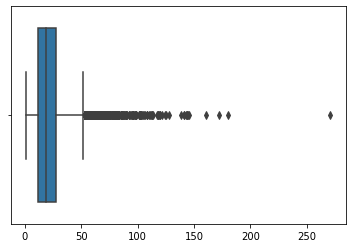

In [ ]:
sns.boxplot(lengths)
plt.show()

In [ ]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [ ]:
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0  6423 24231
     2  7652   102   170     2    47  1898     1   269    17     7 13230
   619  1711  2761     3] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  1  3 11  1  6  3  2  2  5  1  4  5  6
  1  1 11  3]


In [ ]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

# Word Embeddings 

Instead of encoded each word and tag as an integer we'll be using word embedding to represent input words (X) and tags (Y). 

But total **tags is 13** so **one-hot encoding** is good enough.   

To use word embeddings, you can go for either of the following models:
1. word2vec model: https://code.google.com/archive/p/word2vec/
2. GloVe model : https://nlp.stanford.edu/projects/glove/




## Mount Drive & Load Word2Vec

In [3]:
# Use student account 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Pretrained Word2Vec model 
word2vec_path = "/content/drive/MyDrive/Word2Vec/GoogleNews-vectors-negative300.bin.gz" 

In [ ]:
# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
# word2vec effectiveness
word2vec.most_similar(positive = ["King", "Woman"], negative = ["Man"])

[('Queen', 0.4929388165473938),
 ('Tupou_V.', 0.45174291729927063),
 ('Oprah_BFF_Gayle', 0.4422132670879364),
 ('Jackson', 0.440250426530838),
 ('NECN_Alison', 0.43312832713127136),
 ('Whitfield', 0.42834725975990295),
 ('Ida_Vandross', 0.42084527015686035),
 ('prosecutor_Dan_Satterberg', 0.42075902223587036),
 ('martin_Luther_King', 0.42059648036956787),
 ('Coretta_King', 0.42027339339256287)]

## Word2Vec for words (X)   
**EMBEDDING SIZE = 300** 

**VOCABULARY SIZE = 59449** 



In [ ]:
# assign word vectors from word2vec model

EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [ ]:
# check embedding dimension
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (59449, 300)


In [ ]:
# let's look at an embedding of a word
embedding_weights[word_tokenizer.word_index['joy']]

array([ 0.4453125 , -0.20019531,  0.20019531, -0.03149414,  0.078125  ,
       -0.390625  ,  0.13671875, -0.13867188,  0.05395508,  0.10546875,
       -0.05029297, -0.23730469,  0.19921875,  0.12597656, -0.12695312,
        0.34179688,  0.06347656,  0.26757812, -0.07324219, -0.29101562,
        0.10498047,  0.11914062,  0.23730469,  0.00640869,  0.12451172,
       -0.00939941, -0.02770996,  0.03076172,  0.07421875, -0.22851562,
       -0.08056641, -0.05273438,  0.16894531,  0.19824219, -0.15625   ,
       -0.08740234,  0.10742188, -0.07177734,  0.05200195,  0.25976562,
        0.171875  , -0.13574219,  0.06738281,  0.00531006,  0.15527344,
       -0.03515625,  0.08789062,  0.3359375 , -0.12890625,  0.17578125,
       -0.08642578,  0.32421875, -0.09033203,  0.35351562,  0.24316406,
       -0.07470703, -0.06640625, -0.17578125,  0.06689453, -0.03833008,
        0.0100708 , -0.21484375, -0.03686523,  0.04394531,  0.02209473,
        0.00219727, -0.22460938,  0.03015137, -0.21582031,  0.16

## One-hot encoding for tags (Y)

In [ ]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [ ]:
# print Y of the first output sequence
print(Y.shape)

(72202, 100, 13)


# Traing,validation test sets split 

Ratio [training and validation], test sets is **0.85, 0.15** 

In [ ]:
TRAIN_SIZE = 0.85
TEST_SIZE = 0.15

In [ ]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [ ]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [ ]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (52165, 100)
Shape of output sequences: (52165, 100, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (9206, 100)
Shape of output sequences: (9206, 100, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (10831, 100)
Shape of output sequences: (10831, 100, 13)


**Shape of X: (#samples, #timesteps, #features)**

**Shape of Y: (#samples, #timesteps, #features)** 

# Long-Short Term Memory 

In [ ]:
# total number of tags
NUM_CLASSES = Y.shape[2]

## Model Architecture 

In [ ]:
# create architecture

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile Model 

In [ ]:
# compile model 
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])

## Fit model 

In [ ]:
lstm_training = lstm_model.fit(X_train, Y_train, 
                               batch_size=128, epochs=100, 
                               validation_data=(X_validation, Y_validation))

Epoch 1/100
408/408 [==============================] - 217s 526ms/step - loss: 0.6754 - acc: 0.8742 - val_loss: 0.0498 - val_acc: 0.9871
Epoch 2/100
408/408 [==============================] - 210s 514ms/step - loss: 0.0398 - acc: 0.9889 - val_loss: 0.0305 - val_acc: 0.9899
Epoch 3/100
 57/408 [===>..........................] - ETA: 2:53 - loss: 0.0262 - acc: 0.9914

KeyboardInterrupt: ignored

In [ ]:
# visualise training history
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## Save trained model 

In [ ]:
# This saved as *.pb format
save_path = "/content/drive/MyDrive/Word2Vec/" 
lstm_model.save(save_path)

In [ ]:
# Save trained model as json


## Load trained model 

In [ ]:
# load model 
# lstm_model.load(save_path)

# Model Evaluation

# Custom Loss Function (POSTPONED)

In [ ]:
def compute_accuracy(pred, y):
    '''
    Input: 
        pred: a list of the predicted parts-of-speech 
        y: a list of lines where each word is separated by a '\t' (i.e. word \t tag)
    Output: 
        
    '''
    num_correct = 0
    total = 0
    
    # Zip together the prediction and the labels
    for prediction, y in zip(pred, y):
        ### START CODE HERE (Replace instances of 'None' with your code) ###
        # Split the label into the word and the POS tag
        word_tag_tuple = y.split()
        
        # Check that there is actually a word and a tag
        # no more and no less than 2 items
        if len(word_tag_tuple) != 2:
            continue

        # store the word and tag separately
        word, tag = word_tag_tuple
        
        # Check if the POS tag label matches the prediction
        if prediction == tag: 
            
            # count the number of times that the prediction
            # and label match
            num_correct += 1
            
        # keep track of the total number of examples (that have valid labels)
        total += 1
        
        ### END CODE HERE ###
    return num_correct / total

In [ ]:
# compile model 
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])

In [ ]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          17834700  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           93440     
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 13)           845       
Total params: 17,928,985
Trainable params: 17,928,985
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss, accuracy = lstm_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 9s 28ms/step - loss: 0.0252 - acc: 0.9916
Loss: 0.025211013853549957,
Accuracy: 0.9916166663169861


# LSTM on Custom Dataset 
Custom dataset without label: https://github.com/Dokkaebi00/POS_Tagging-with-HMM/blob/master/dataset_NLP.txt

Custom dataset with label: https://github.com/Dokkaebi00/POS_Tagging-with-HMM/blob/master/dataset_NLP_label.txt

## Load custom dataset

In [4]:
# Load custom dataset

# github link  
# custom_data_path = "https://raw.githubusercontent.com/Dokkaebi00/POS_Tagging-with-HMM/master/dataset_NLP_label.txt" 

# drive link 
custom_data_path = "/content/drive/MyDrive/Word2Vec/dataset_NLP_label.txt"

with open(custom_data_path) as f:
    tagged_sentences = f.readlines()

for idx in range(5): 
  print(tagged_sentences[idx])



In	IN

an	DT

Oct.	NNP

19	CD



## Preprocessing 

In [5]:
X = [] # store words 
Y = [] # store tags 

In [6]:
# # Error with this 
# for sentence in tagged_sentences:
#     X_sentence = []
#     Y_sentence = []
#     for entity in sentence:         
#       try: 
#         X_sentence.append(entity[0])  # entity[0] contains the word
#         Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
#       except IndexError: 
#         continue 
#     X.append(X_sentence)
#     Y.append(Y_sentence)

# # Error with this 
for idx,line in enumerate(tagged_sentences): 
    try: 
        word,tag = line.split()
        # print('Word', word)
        # print('Tag', tag)
        if (word == '\s' or tag == '\s'): 
            print("Empty line {}".format(idx))
            continue
        X.append(word)
        Y.append(tag)
    except ValueError:
        pass 

In [7]:
print('X[1]',X[1])
print('Y[1]',Y[1])

X[1] an
Y[1] DT


In [ ]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [ ]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 4695
Vocabulary size: 50
Total number of tags: 24


In [ ]:
# let's look at first data point
# this is one data point that will be fed to the RNN
for idx in range(5): 
  print('sample X[{}]: {} , Y[{}]: {} \n'.format(idx,X[idx],idx,Y[idx]))

sample X[0]: In , Y[0]: IN 

sample X[1]: an , Y[1]: DT 

sample X[2]: Oct. , Y[2]: NNP 

sample X[3]: 19 , Y[3]: CD 

sample X[4]: review , Y[4]: NN 



In [ ]:
# encode X
word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

## Vectorize X and Y 

In [ ]:
# encode X
word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [ ]:
# encode Y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [ ]:
# look at first encoded data point
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  In 

Y:  IN 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [5] 

Y:  [2] 



In [ ]:
# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

130 sentences have disparate input-output lengths.


## Word Embedding for words (X)  

## One-hot Encoding for tags (Y)  

In [ ]:
# Y = to_categorical(Y) 

ValueError: ignored

In [ ]:
for idx in range(len(Y)): 
  try: 
    Y[idx] = to_categorical(Y[idx])  
  except ValueError: 
    print("Error at line {}, value {}".format(idx,Y[idx]))

Streaming output truncated to the last 5000 lines.
Error at line 2825, value NNP
Error at line 2826, value NNP
Error at line 2827, value ,
Error at line 2828, value CD
Error at line 2829, value NNS
Error at line 2830, value JJ
Error at line 2831, value ,
Error at line 2832, value DT
Error at line 2833, value JJ
Error at line 2834, value NN
Error at line 2835, value NN
Error at line 2836, value IN
Error at line 2837, value DT
Error at line 2838, value VBG
Error at line 2839, value NN
Error at line 2840, value ,
Error at line 2841, value VBD
Error at line 2842, value VBN
Error at line 2843, value NN
Error at line 2844, value IN
Error at line 2845, value PRP$
Error at line 2846, value NN
Error at line 2847, value NN
Error at line 2848, value ,
Error at line 2849, value DT
Error at line 2850, value JJ
Error at line 2851, value NN
Error at line 2852, value .
Error at line 2853, value JJ
Error at line 2854, value NN
Error at line 2855, value NNS
Error at line 2856, value VBP
Error at line 28

In [ ]:
print(Y.shape)

AttributeError: ignored

## SKlearn One-Hot Encoding 

Ref: https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

In [1]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder